[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lowry777/3253-Project_Group-18/blob/main/Group18_3253_Project-Toronto_Shelter_Occupancy.ipynb)

## **Toronto Daily Shelter Occupancy Overview**

The data set provides a listing of all the active shelters serving the City of Toronto area. Included in the dataset is the name of the shelter, program name, sector served (i.e. men, women, youth, families) addresses, program capacity, and the number of people that occupied those spaces at 4:00 AM the next morning.

Data limitations:
- Data entry errors such as address, capacity blank and occupancy blank or 0
- Facilty address not provided

# Import Standard Librairies

In [2]:
#Import standard librairies
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import uniform
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, TimeSeriesSplit, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC


#from google.colab import drive
#drive.mount('/content/gdrive')

# Load and Clean Data

In [3]:
#load data from online csv details: https://open.toronto.ca/dataset/daily-shelter-occupancy/
csvs = ["https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/23efca84-00ff-4738-afbb-1cd6fa9cf5dc","https://ckan0.cf.opendata.inter.prod-toronto.ca/datastore/dump/f44e3cef-5663-436a-838f-f444dd1d0c92", "https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/8a6eceb2-821b-4961-a29d-758f3087732d/resource/c8bc0bf8-5cef-48e7-9606-7277f8efd6d6/download/smis_daily_occupancy_2019.csv"] #2017, 2018, 2019
merged = []
year = 2017

for c in csvs:
  read = pd.read_csv(c)
  read["file_year"] = year
  year = year + 1
  merged.append(read)

df_orig = pd.concat(merged)
df_orig

,_id,OCCUPANCY_DATE,ORGANIZATION_NAME,SHELTER_NAME,SHELTER_ADDRESS,SHELTER_CITY,SHELTER_PROVINCE,SHELTER_POSTAL_CODE,FACILITY_NAME,PROGRAM_NAME,SECTOR,OCCUPANCY,CAPACITY,file_year
0,1.0,2017-01-01T00:00:00,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0,2017
1,2.0,2017-01-01T00:00:00,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0,2017
2,3.0,2017-01-01T00:00:00,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0,2017
3,4.0,2017-01-01T00:00:00,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0,2017
4,5.0,2017-01-01T00:00:00,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39441,NaN,12/31/2019,YWCA Toronto,YWCA-348 Davenport,348 Davenport Rd.,Toronto,ON,M5R 1K6,YWCA - 348 Davenport Road Youth,YWCA Davenport - Youth,Youth,15,15.0,2019
39442,NaN,12/31/2019,Youth Without Shelter,Youth Without Shelter,6 Warrendale Court,Etobicoke,ON,M9V 1P9,Youth w/o Shelter Emerg Shelter,Youth without Shelter Emergency Shelter Program,Youth,33,33.0,2019
39443,NaN,12/31/2019,Youth Without Shelter,Youth Without Shelter,6 Warrendale Court,Etobicoke,ON,M9V 1P9,Youth w/o Shltr Transitional Res,Youth without Shelter Stay In School Program,Youth,20,20.0,2019
39444,NaN,12/31/2019,YouthLink,YouthLink Shelter,747 Warden Ave,Toronto,ON,M1L 4A1,YouthLink - 747 Warden Ave,YouthLink Emergency Program,Co-ed,9,10.0,2019


In [4]:
#rename headers to simpler and lower case names
df = df_orig.rename(columns={'_id': 'id','OCCUPANCY_DATE':'date','ORGANIZATION_NAME':'organization','SHELTER_NAME':'shelter','SHELTER_ADDRESS':'address','SHELTER_CITY':'city','SHELTER_PROVINCE':'prov','SHELTER_POSTAL_CODE':'postcode','FACILITY_NAME':'facility','PROGRAM_NAME':'program','SECTOR':'sector'}).drop(['id','file_year'], axis=1)
df.columns = map(str.lower, df.columns)
df['shelter'] = df.shelter.replace({'Kennedy House Youth shelter': 'Kennedy House Youth Shelter'}) #clean lower case shelter to avoid unncessary splitting from records with upper case Shelter
df['program'] = df.program.replace({'CLOSED University Settlement - Out of the Cold': 'University Settlement - Out of the Cold'}) #removed CLOSED to avoid unncessary splitting from records without closed
df.head()

,date,organization,shelter,address,city,prov,postcode,facility,program,sector,occupancy,capacity
0,2017-01-01T00:00:00,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0
1,2017-01-01T00:00:00,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0
2,2017-01-01T00:00:00,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0
3,2017-01-01T00:00:00,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0
4,2017-01-01T00:00:00,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0


In [5]:
#Engineer date into component parts
df['date'] = pd.to_datetime(df.date)
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year
df['day'] = pd.DatetimeIndex(df['date']).day
df['weekday'] = pd.DatetimeIndex(df['date']).weekday #Note Monday = 0, Sunday = 6
# To consider: Add a day/year (Dec-31) to account for holidays or factors unique to specific day of year?
df.head()

,date,organization,shelter,address,city,prov,postcode,facility,program,sector,occupancy,capacity,month,year,day,weekday
0,2017-01-01,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0,1,2017,1,6
1,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0,1,2017,1,6
2,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0,1,2017,1,6
3,2017-01-01,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0,1,2017,1,6
4,2017-01-01,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0,1,2017,1,6


In [6]:
import fileinput
#weather data downloaded as per https://climate.weather.gc.ca/historical_data/search_historic_data_e.html using Cygwin64 Terminal for Toronto Intl A weather station 
#filePath ="/content/gdrive/My Drive/Colab Notebooks/U of T/3253/Project/en_climate_daily_toronto_intl_A_2017_2019.csv"
#weather_orig = pd.read_csv(filePath, sep=",")

url = 'https://raw.githubusercontent.com/lowry777/3253-Project_Group-18/main/en_climate_daily_toronto_intl_A_2017_2019.csv'
weather_orig = pd.read_csv(url)

weather = weather_orig[['Date/Time','Max Temp (°C)','Min Temp (°C)','Total Rain (mm)', 'Total Snow (cm)','Snow on Grnd (cm)','Spd of Max Gust (km/h)']].copy()
weather.rename(columns={'Date/Time': 'date','Max Temp (°C)':'max_temp','Min Temp (°C)':'min_temp','Total Rain (mm)':'rain','Total Snow (cm)':'snow','Snow on Grnd (cm)': 'snow_ground', 'Spd of Max Gust (km/h)': 'max_gust'},inplace=True)
weather['date'] = pd.to_datetime(weather.date)
#weather = weather.query('20170101 <= date <= 20191231')
df = pd.merge(df, weather, on ='date', how ='left')
df['max_gust'] = df.max_gust.replace({'<31': 30}).astype(float) #replace <31 flag string with 30 for numerical calculations
df.snow_ground.fillna(value=0, inplace=True) #many blanks, assume blanks are no snow on ground based on no missing flag in source
df.head()

,date,organization,shelter,address,city,prov,postcode,facility,program,sector,occupancy,capacity,month,year,day,weekday,max_temp,min_temp,rain,snow,snow_ground,max_gust
0,2017-01-01,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0
1,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0
2,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0
3,2017-01-01,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0
4,2017-01-01,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0


In [ ]:
df.info()
#df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115916 entries, 0 to 115915
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          115916 non-null  datetime64[ns]
 1   organization  115916 non-null  object        
 2   shelter       115916 non-null  object        
 3   address       115916 non-null  object        
 4   city          115916 non-null  object        
 5   prov          115916 non-null  object        
 6   postcode      110422 non-null  object        
 7   facility      115916 non-null  object        
 8   program       115916 non-null  object        
 9   sector        115916 non-null  object        
 10  occupancy     115916 non-null  int64         
 11  capacity      115573 non-null  float64       
 12  month         115916 non-null  int64         
 13  year          115916 non-null  int64         
 14  day           115916 non-null  int64         
 15  weekday       115

In [7]:
#Join in lat/long 

#Confirmed 1 address per shelter
#pd.set_option('display.max_rows', 100) #shows 100 rows
#pd.reset_option('display.max_rows') #resets back to normal output
#unique_shelter = df.groupby('shelter')['address'].agg(['first','count','nunique']).reset_index(drop=False)
#unique_shelter['count'].sum() == unique_shelter['shelter'].count()

#Unique shelters for geocoding locations - Only ran once to generate csv to avoid triggering geocoding limits

#from geopy.geocoders import Nominatim
#geolocator = Nominatim(user_agent="ML School Project Group 18")

#shelter_loc = df[['shelter','address','city','prov','postcode']].drop_duplicates(subset = ['shelter']) #get unique list of shelter and location info
#shelter_loc['address'] = shelter_loc.address.replace({'Bathrust': 'Bathurst', ', 2nd floor': ''}, regex=True) #Correct errors in source data to allow match, regex=True allows for instring search
#shelter_loc['full_address'] = shelter_loc.address + ',' + shelter_loc.city + ',' + shelter_loc.prov + ',' #concat to pass to geocode search, note postcal code didn't work well so removed
#shelter_loc['gcode'] = shelter_loc.full_address.apply(geolocator.geocode) #returns full geocode
#shelter_loc['lat'] = [g.latitude for g in shelter_loc.gcode] #extract lat from geocode
#shelter_loc['long'] = [g.longitude for g in shelter_loc.gcode] #extract long from geocode

#from google.colab import files
#shelter_loc.to_csv('shelter_loc.csv', index=False)
#files.download('shelter_loc.csv')


#Note for future geocode can try set up as dictionary for improved search such as:
#location = geolocator.geocode({'street': '100 Lippincott Street', 'city': 'Toronto', 'state': 'Ontario', 'country': 'Canada'})
#print(location.address)
#print((location.latitude, location.longitude))

#filePath ="/content/gdrive/My Drive/Colab Notebooks/U of T/3253/Project/shelter_loc.csv"
#shelter_loc = pd.read_csv(filePath, sep=",")

url = 'https://raw.githubusercontent.com/lowry777/3253-Project_Group-18/main/shelter_loc.csv'
shelter_loc = pd.read_csv(url)

df = pd.merge(df, shelter_loc[['shelter','lat', 'long']], on ='shelter', how ='left') 
df.head()

,date,organization,shelter,address,city,prov,postcode,facility,program,sector,occupancy,capacity,month,year,day,weekday,max_temp,min_temp,rain,snow,snow_ground,max_gust,lat,long
0,2017-01-01,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.657927,-79.407106
1,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.665860,-79.445919
2,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.665860,-79.445919
3,2017-01-01,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.665172,-79.418864
4,2017-01-01,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.691590,-79.264226


In [8]:
#Create percent occupied (occ_perc) and full (1, 0)
df['occ_perc'] = df.occupancy / df.capacity
df['full'] = df['occ_perc'].apply(lambda x: 1 if x >= 1 else 0) #Full if occupancy is greater or equal to
df.head()

,date,organization,shelter,address,city,prov,postcode,facility,program,sector,occupancy,capacity,month,year,day,weekday,max_temp,min_temp,rain,snow,snow_ground,max_gust,lat,long,occ_perc,full
0,2017-01-01,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.657927,-79.407106,1.000000,1
1,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Extreme Weather Program,Men,13,17.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.665860,-79.445919,0.764706,0
2,2017-01-01,Christie Ossington Neighbourhood Centre,Christie Ossington Men's Hostel,973 Lansdowne Avenue,Toronto,ON,M6H 3Z5,Christie Ossington Men's Hostel,Christie Ossington Men's Hostel,Men,63,63.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.665860,-79.445919,1.000000,1
3,2017-01-01,"Christie Refugee Welcome Centre, Inc.",Christie Refugee Welcome Centre,43 Christie Street,Toronto,ON,M6G 3B1,Christie Refugee Welcome Centre,Christie Refugee Welcome Ctr - Settlement and ...,Families,66,70.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.665172,-79.418864,0.942857,0
4,2017-01-01,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60.0,1,2017,1,6,1.8,-2.5,0.0,0.0,3.0,50.0,43.691590,-79.264226,0.966667,0


In [ ]:
#Check data
#df.describe() # occ_perc needs to be cleaned
df.info() # nulls for postcode, capacity and occ_perc. Clean capacity

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115916 entries, 0 to 115915
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          115916 non-null  datetime64[ns]
 1   organization  115916 non-null  object        
 2   shelter       115916 non-null  object        
 3   address       115916 non-null  object        
 4   city          115916 non-null  object        
 5   prov          115916 non-null  object        
 6   postcode      110422 non-null  object        
 7   facility      115916 non-null  object        
 8   program       115916 non-null  object        
 9   sector        115916 non-null  object        
 10  occupancy     115916 non-null  int64         
 11  capacity      115573 non-null  float64       
 12  month         115916 non-null  int64         
 13  year          115916 non-null  int64         
 14  day           115916 non-null  int64         
 15  weekday       115

In [ ]:
#check nulls for occ_perc
#filtered_df = df[df['occ_perc'].isnull()]
#filtered_df
#Many 0s for capacity and some for occupancy...assume some true and some errors. Remove records where capacity is null or 0. Some cases where 0 occupancy might be input errors 

In [9]:
df.dropna(subset=['capacity'],inplace = True)
df = df[df.capacity!=0]
#df

In [ ]:
#df.describe() #looks good
#df.info() #113372 unique values remaining

In [10]:
df = df.sort_values(by=['program','date'], ascending=[True, True])
df['prior_day_occ_perc'] = df['occ_perc'].shift() #Not an ideal solution, doesn't capture if same program or is actually prior day but good enough for now
df.prior_day_occ_perc.fillna(df.prior_day_occ_perc.bfill(), inplace=True)# Should happen after train test split since leaking in somee infor 
#df[:100]

#for i in range(len(df)):
#    if df.loc[i,"program"] == df.loc[i-1,"program"] and df.loc[i,"date"] == df.loc[i-1,"date"] + pd.DateOffset(-1)
#        df.loc[i,"prior_day_occ_perc"] = df.loc[i-1,"occ_perc"]
#    else:
#        None

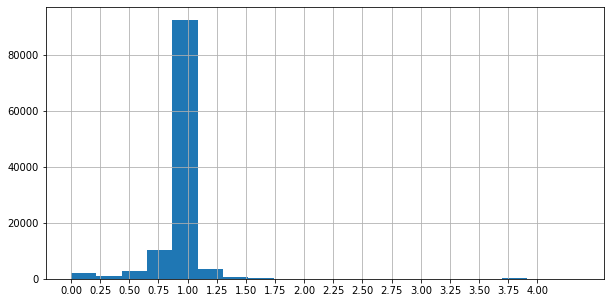

In [11]:
ax = df.occ_perc.hist(bins=20, figsize=(10,5))
ax = plt.xticks(np.linspace(0,4,17))

In [12]:
#Drop outliers
filtered = df[df['occ_perc'] > 1.4].groupby('program')['program'].agg(['count']) 

filtered = df.set_index(['program']).occ_perc.rename('>=1.4').ge(1.4)  \
  .groupby(level=[0]).value_counts(True).unstack(fill_value=0)

filtered.loc[['Family Residence - Main','Family Residence - TO site (Internal Referral Only)']] 

df = df[df.occ_perc < 1.4]

In [ ]:
#pd.set_option('display.max_rows', 200) #shows 100 rows
#pd.reset_option('display.max_rows') #resets back to normal output
#unique_facility = df.groupby(['shelter','facility'])['facility'].agg(['count'])
#unique_facility
#most shelters have multiple facilities, seem to be at different addresses. Maybe remove shelter?

In [ ]:
#unique_program = df.groupby(['program','facility'])['program'].agg(['count'])
#unique_program
#most programs are unique to facility maybe only need program?

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112206 entries, 111136 to 115915
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date                112206 non-null  datetime64[ns]
 1   organization        112206 non-null  object        
 2   shelter             112206 non-null  object        
 3   address             112206 non-null  object        
 4   city                112206 non-null  object        
 5   prov                112206 non-null  object        
 6   postcode            106712 non-null  object        
 7   facility            112206 non-null  object        
 8   program             112206 non-null  object        
 9   sector              112206 non-null  object        
 10  occupancy           112206 non-null  int64         
 11  capacity            112206 non-null  float64       
 12  month               112206 non-null  int64         
 13  year                1122

In [15]:
df.sort_values(by='date', ascending=True, inplace=True)
df_ml = df.drop(['date','address','city','occupancy','prov','postcode','rain','snow','lat','long','organization','shelter','facility'], axis=1)#.replace([np.inf, -np.inf], np.nan).dropna()
df_ml

,program,sector,capacity,month,year,day,weekday,max_temp,min_temp,snow_ground,max_gust,occ_perc,full,prior_day_occ_perc
64,Native Child & Family Services Toronto,Youth,12.0,1,2017,1,6,1.8,-2.5,3.0,50.0,0.916667,0,1.000000
60,Kennedy House Youth Shelter: Bedded Program,Youth,33.0,1,2017,1,6,1.8,-2.5,3.0,50.0,1.000000,1,0.938462
14,Family Residence - Main,Families,110.0,1,2017,1,6,1.8,-2.5,3.0,50.0,1.345455,1,1.125000
58,Homes First Society - Strachan House,Co-ed,83.0,1,2017,1,6,1.8,-2.5,3.0,50.0,0.987952,0,1.000000
81,Salvation Army - Florence Booth Womens Ministry,Women,60.0,1,2017,1,6,1.8,-2.5,3.0,50.0,1.000000,1,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115911,YWCA Davenport - Youth,Youth,15.0,12,2019,31,1,2.3,-1.5,1.0,54.0,1.000000,1,1.000000
115887,S.A. Evangeline - Emergency Weather,Women,9.0,12,2019,31,1,2.3,-1.5,1.0,54.0,1.000000,1,1.000000
115822,Robertson House - MAIN Program,Families,90.0,12,2019,31,1,2.3,-1.5,1.0,54.0,1.222222,1,1.244444
115813,Downsview Dells Bedded Program,Men,28.0,12,2019,31,1,2.3,-1.5,1.0,54.0,0.821429,0,0.928571


# Exploratory Data Analysis

In [ ]:
# occupancy %, percent full, capacity by shelter, visualization on map, cut by program where possible, correlation 

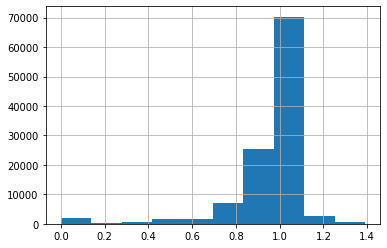

In [16]:
df.occ_perc.hist()
#Outliers removed earlier, note often at or very near capacity

In [17]:
df.full.mean()

0.565789708215247

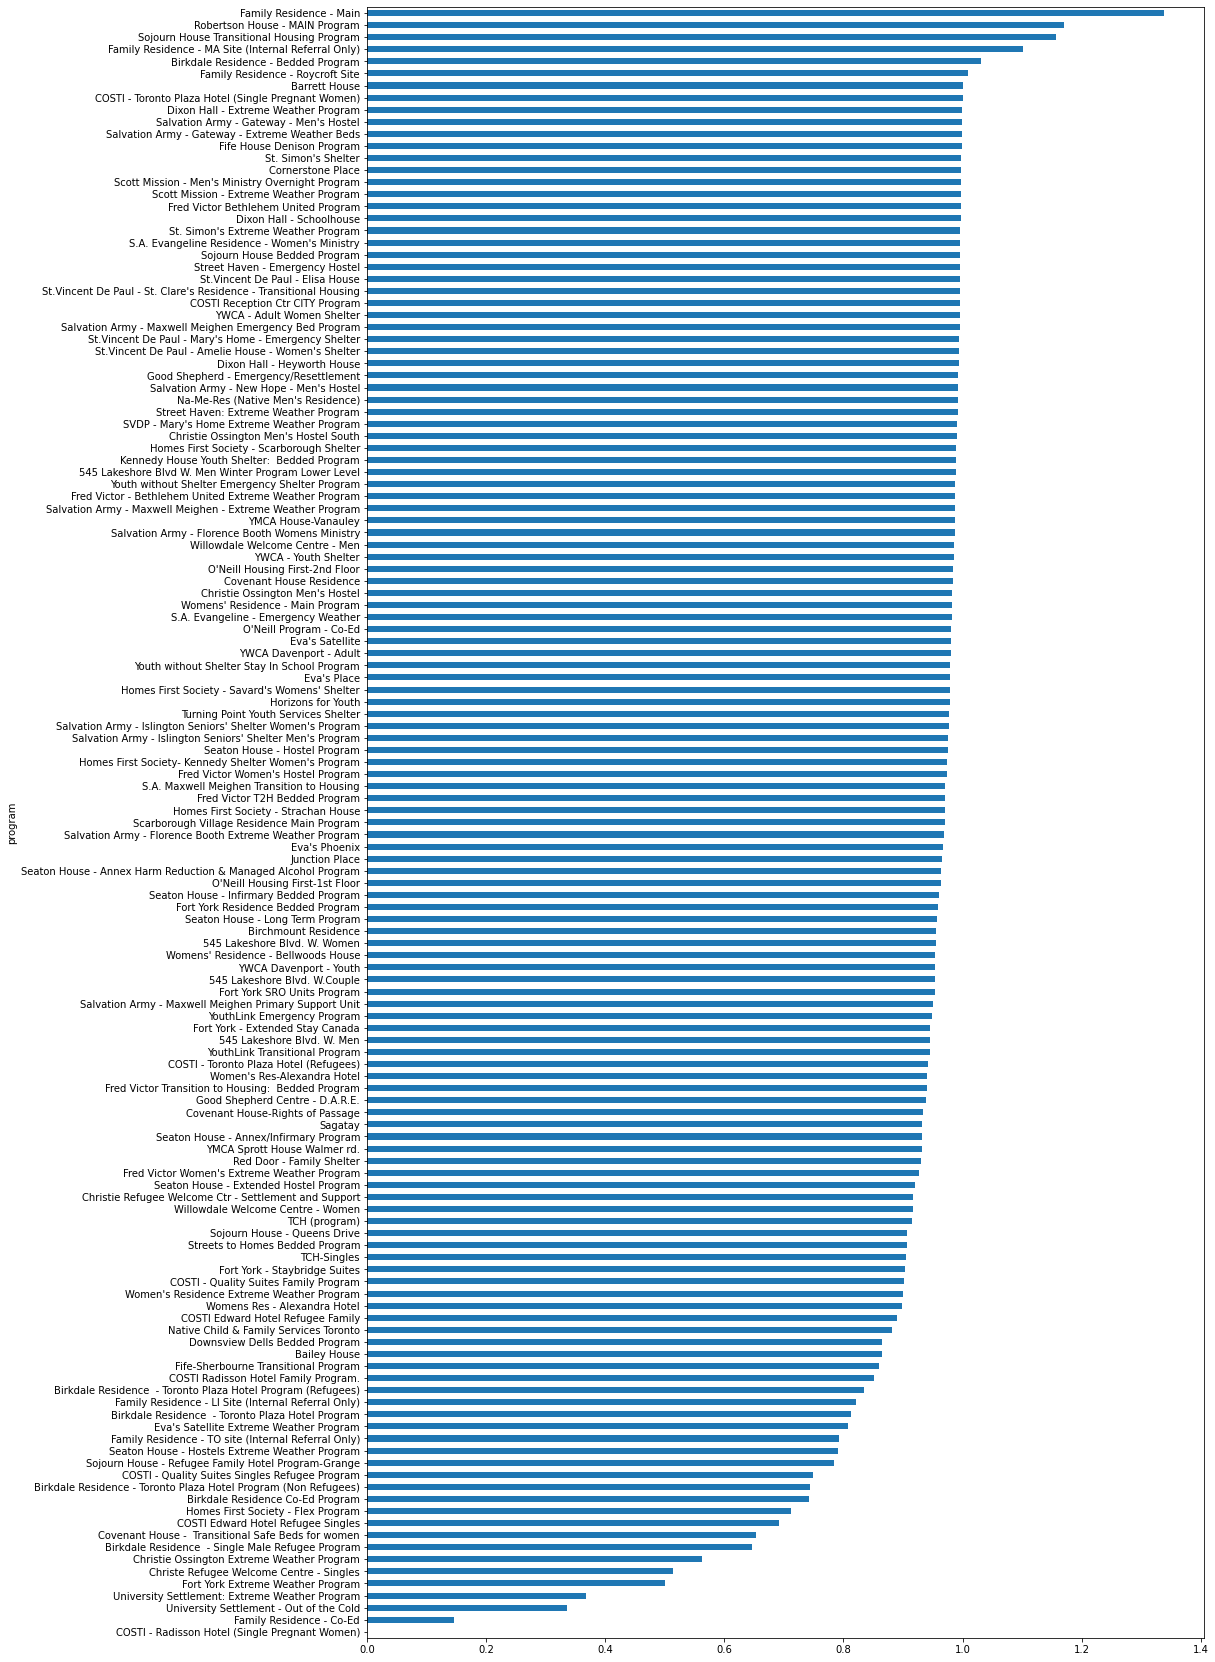

In [18]:
df.groupby('program').occ_perc.mean().sort_values(ascending=True).plot.barh(figsize=(15,30))

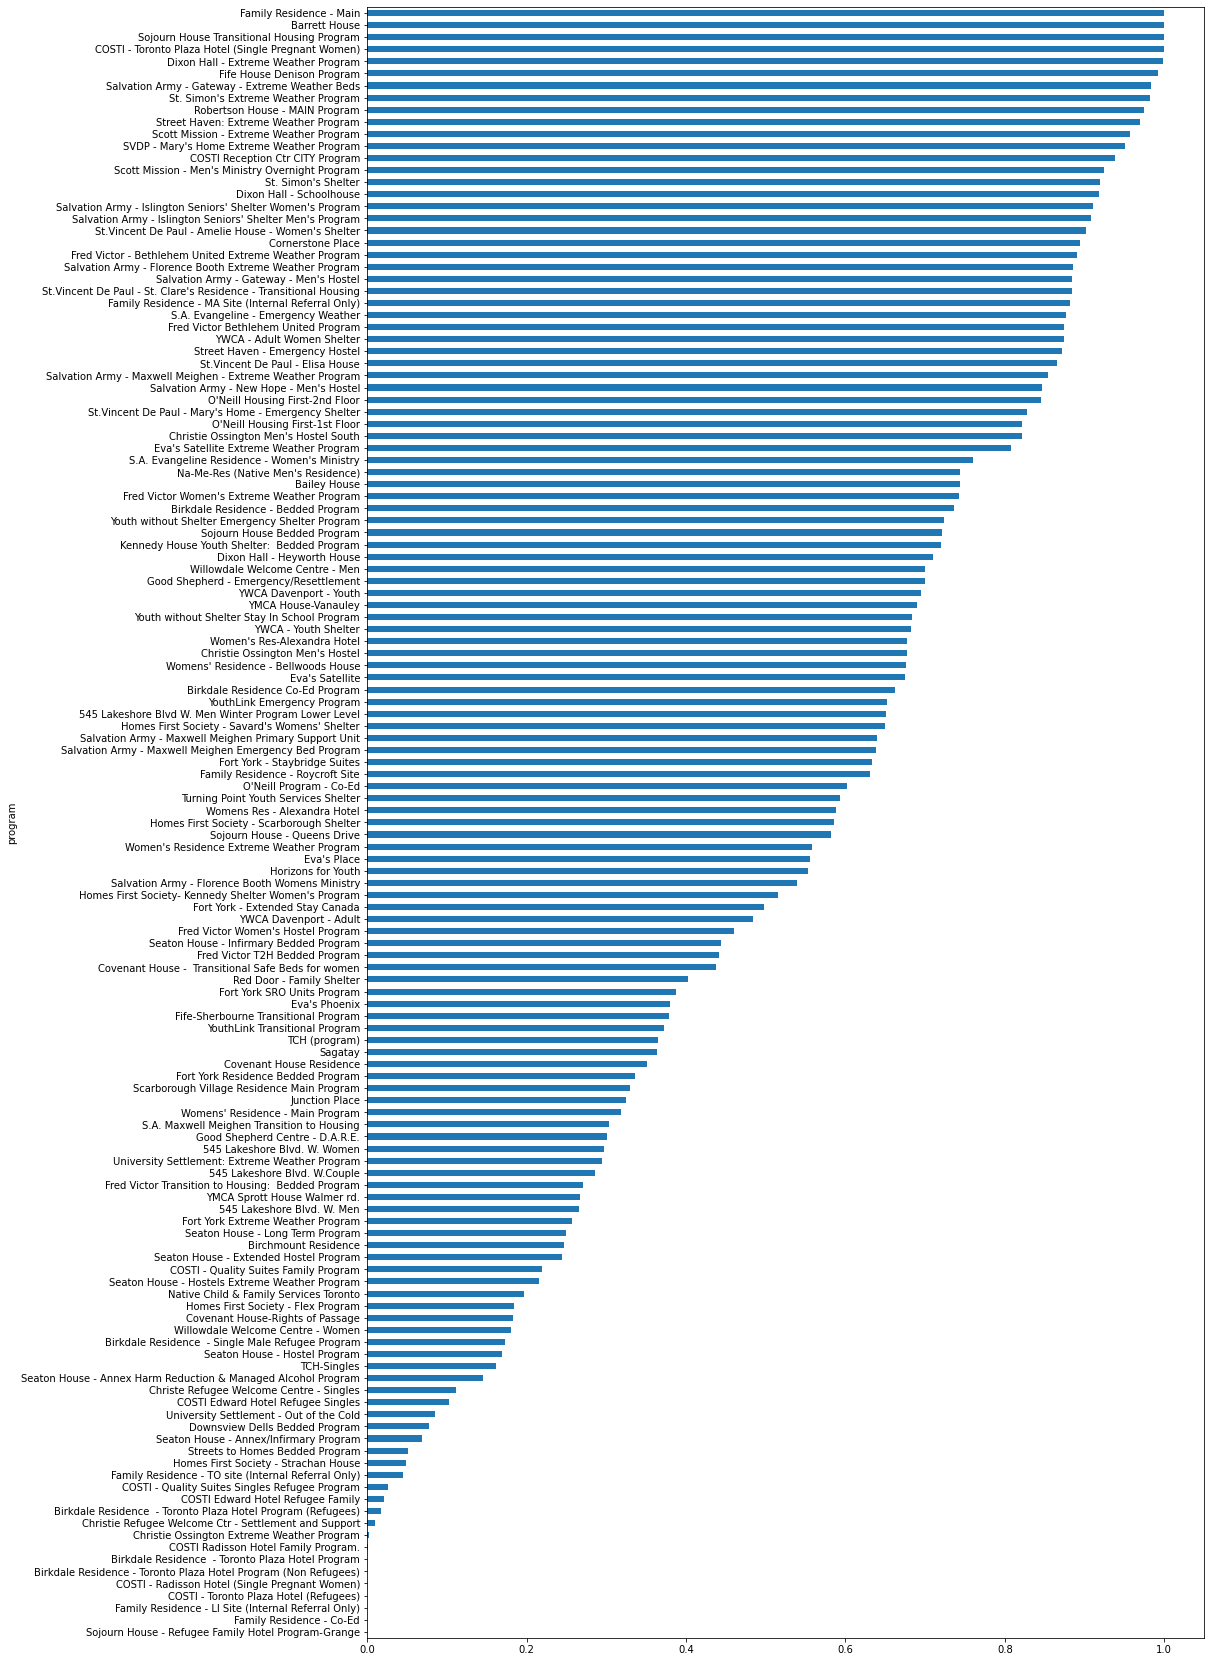

In [ ]:
df.groupby('program').full.mean().sort_values(ascending=True).plot.barh(figsize=(15,30))

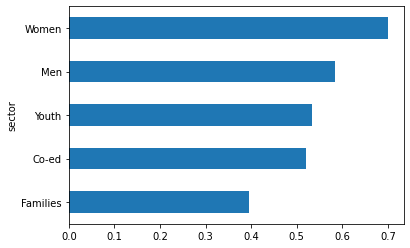

In [ ]:
df.groupby('sector').full.mean().sort_values(ascending=True).plot.barh()

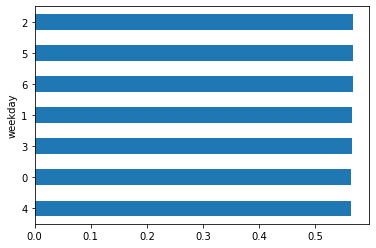

In [ ]:
df.groupby('weekday').full.mean().sort_values(ascending=True).plot.barh()

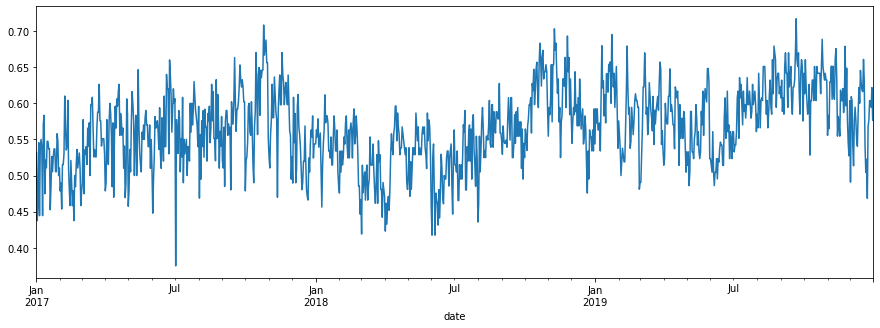

In [ ]:
df.groupby('date').full.mean().plot(figsize=(15,5))
#lower occupancy in summer

numpy.ndarray

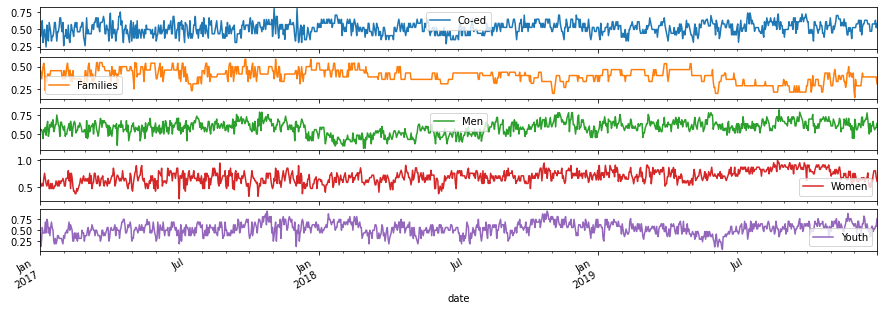

In [27]:
axes = df.groupby(['date','sector']).full.mean().unstack().plot(figsize=(15,5),subplots=True)
type(axes)

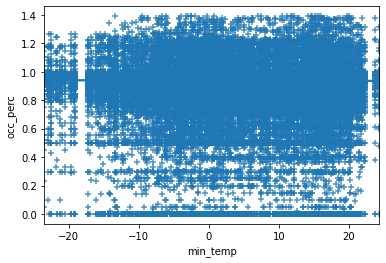

In [ ]:
#df.plot.scatter(x='min_temperature', y='occ_perc', c='DarkBlue')
sns.regplot(x='min_temp', y='occ_perc', data=df, marker="+")

In [ ]:
import plotly.express as px

df_map = df.groupby(['shelter','lat','long']).agg({'occ_perc': ['mean'],'full':['mean']})
# rename columns
df_map.columns = ['occ_perc_mean', 'full_mean']
# reset index to get grouped columns back
df_map = df_map.reset_index()

#px.scatter_geo(df_map, lat='lat', lon='long',size='full_mean', hover_name='shelter', text = 'occ_perc_mean', color='full_mean', color_continuous_scale = 'hot_r')

px.set_mapbox_access_token('pk.eyJ1Ijoiamdvb2R6OCIsImEiOiJja2hzanlhaGcwc25vMnhtam9rOTkyM3gxIn0.SGKwXjSu9-j0Mc5wUVJ9Qg')

fig = px.scatter_mapbox(df_map, lat="lat", lon="long", color="full_mean", size="full_mean", hover_name='shelter',
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()

# Pipeline

In [ ]:
from sklearn.model_selection import train_test_split
#split train and test sets
train_set, test_set = train_test_split(df_ml, test_size=0.4, random_state=123)
#Consider sort by date and take first 2/3, shuffle = false

# Separate Exploratory (X) from target (y)
X_train = train_set.drop(['occ_perc','full'], axis=1) # drop label for training set
y_train = train_set['full'].copy()

X_test = test_set.drop(['occ_perc','full'], axis=1) # drop label for training set
y_test = test_set['full'].copy()


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# prepare data pipeline
# numerical values scaled using standard scaler and built in median imputer just in case despite no null values observed
num_X = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_X = X_train.select_dtypes(include=['object', 'bool']).columns
#date_X = X_train.select_dtypes(include=['datetime64[ns]']).columns

# create pipeline
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),                 
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_X),
        ("cat", OneHotEncoder(), cat_X),
        #('date', SimpleImputer(), date_X)
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

In [ ]:
print(X_train_prepared.shape)
print(X_test_prepared.shape)

(67323, 150)
(44883, 150)


In [ ]:
#time series based

# ML Model Testing & Hyperparameter Tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# fit random forecast classifier
forest_clf = RandomForestClassifier(random_state=123, oob_score=True)
forest_clf.fit(X_train_prepared, y_train)
print(forest.oob_score_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [ ]:
from sklearn.metrics import accuracy_score
y_train_pred = forest_clf.predict(X_train_prepared)
accuracy_score(y_train, y_train_pred)
# overfitting

1.0

In [ ]:
best_random = rf_random.best_estimator_
#cross_val_score(best_random, X_train_prepared, y_train, cv=3, scoring="accuracy")

In [ ]:
from sklearn.model_selection import cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cross_val_score(forest_clf, X_train_prepared, y_train, cv=tscv, scoring="accuracy")

array([0.85828877, 0.86030897, 0.8627451 ])

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

y_train_pred = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3)
print('Accuracy Score:', accuracy_score(y_train, y_train_pred))
print('ROC AUC Score:', roc_auc_score(y_train, y_train_pred))

Accuracy Score: 0.86240957770747
ROC AUC Score: 0.855182168263832


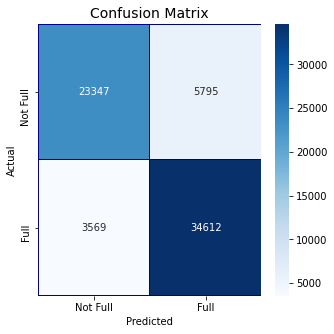

In [ ]:
cm = pd.crosstab(y_train, y_train_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Full', 'Full'],
            yticklabels=['Not Full', 'Full'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt='g')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [ ]:
#Time series based hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier

# Number of trees in random forest (default = 100)
n_estimators = [200, 400]
# Number of features to consider at every split (default = 'auto')
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [100, 200]
# Minimum number of samples required to split a node (default = 2)
min_samples_split = [10, 20, 50]
# Minimum number of samples required at each leaf node (default = 1)
min_samples_leaf = [1, 2, 4]
# Number of leaf nodes (default = None, unlimited )
max_leaf_nodes = [5, None]
# Method of selecting samples for training each tree
bootstrap = [True]

#Create timeseries cv 
tscv = TimeSeriesSplit(n_splits=3)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(RandomForestClassifier(), param_distributions = random_grid, n_iter = 1, cv = tscv, verbose=2, random_state=42, scoring = 'accuracy')
rf_random.fit(X_train_prepared, y_train)
print(rf_random.best_params_)
print(rf_random.best_score_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True, total=  17.6s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.6s remaining:    0.0s


[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True, total=  42.3s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True, total= 1.2min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min finished


{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
0.8641711229946525


In [ ]:
#other classifiers: SVM, SGD (log), KNN, naive bayes, decision tree

In [ ]:
#Check where right/wrong (combined and build groupby by program)
#df_check['rf_pred'] = y_train_pred
#df_checl[['program','full']]= [X_train_prepared

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

clf = KNeighborsClassifier()

y_train_pred = cross_val_predict(clf, X_train_prepared, y_train, cv=3)
print('Accuracy Score:', accuracy_score(y_train, y_train_pred))
print('ROC AUC Score:', roc_auc_score(y_train, y_train_pred))

Accuracy Score: 0.805816734251296
ROC AUC Score: 0.7948777238496929


# Final Model Evaluation

In [ ]:
#Notes: removing some features had limited impact on accuracy, hyperparameter accuracy vs time, balanced, cleaning

In [ ]:
#TA questions: should train/test be time based? mostly unique programs to facility and shelter, can I streamline to avoid so many features (PCA)? 